In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install surprise

     |████████████████████████████████| 11.8 MB 12.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619391 sha256=89c12f8acb7931bdeac94c83143061efa5d97cfce3fff8d7280cbae9ff5fe967
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import accuracy
from surprise import SVDpp
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV


In [4]:
df = pd.read_csv("/content/drive/MyDrive/NetflixProject/Netflix/archive/NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
df["Date"] = pd.to_datetime(df["Date"])
df_movie=pd.read_csv('/content/drive/MyDrive/Netflix/Data/additions/updated_movie_titles.csv')

ID_values=df_movie[df_movie['Year'].isnull()].ID.values
years=[]
for i in ID_values:
  temp=df[df['MovieID']==i].sort_values('Date').iloc[0]
  years.append(temp.Date.year)
temp1=df_movie[df_movie['Year'].isnull()]
count=0
for i in years:
  temp1.Year.values[count]=i
  count=count+1
df_movie.dropna(inplace=True)
df_movie=pd.concat([df_movie,temp1])
df_movie.sort_index(inplace=True)
df_movie.rename(columns = {'ID':'MovieID'}, inplace = True)

In [5]:
dfnew=df.copy()

In [6]:
dfnew=dfnew.merge(df_movie,on='MovieID')
dfnew.head()

,MovieID,CustID,Ratings,Date,Year,Name
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
data_sample=dfnew.sample(200000)

In [9]:
train,test = train_test_split(data_sample[['CustID','MovieID','Ratings']], test_size=0.05)

In [10]:
train.shape

(190000, 3)

In [11]:
test.shape

(10000, 3)

In [12]:
train.head()

,CustID,MovieID,Ratings
59223435,575455,10894,5
36337356,583656,6450,4
98453556,441442,17361,4
88380236,269827,15730,1
35332671,775026,6307,4


Sparse matrix


In [13]:
# Creating a train sparse matrix
train_sparse_matrix = sparse.csr_matrix((train.Ratings.values, (train.CustID.values, train.MovieID.values)))

In [14]:
rows,cols = train_sparse_matrix.shape
presentElements = train_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.99959643432985% 


In [15]:
train_sparse_matrix.shape

(2649427, 17770)

In [16]:
# Creating a test sparse matrix
test_sparse_matrix = sparse.csr_matrix((test.Ratings.values, (test.CustID.values, test.MovieID.values)))

In [17]:
rows,cols = test_sparse_matrix.shape
presentElements = test_sparse_matrix.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.99997875244831% 


In [18]:
test_sparse_matrix.shape

(2649268, 17765)

In [19]:
# get the global average of ratings in our train set.
train_global_average = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
train_global_average

3.6020263157894736

In [20]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

In [21]:
AvgRatingUser = getAverageRatings(train_sparse_matrix, if_user=True)

In [22]:
AvgRatingMovie = getAverageRatings(train_sparse_matrix, if_user=False)

In [23]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sparse_matrix.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sparse_matrix.count_nonzero()))

No of ratings in Our Sampled train matrix is : 190000
No of ratings in Our Sampled test matrix is : 10000


In [24]:
train_users,train_movies,train_ratings = sparse.find(train_sparse_matrix)

In [25]:
startTime = datetime.now()
print("Preparing Train csv file for {} rows".format(len(train_ratings)))
Train_Reg=pd.DataFrame(columns=["User_ID", "Movie_ID", "Global_Average", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
#with open("/content/drive/MyDrive/NetflixProject/Netflix/archive", mode = "w") as data:
count = 0
for user, movie, rating in zip(train_users, train_movies, train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()) #appending global average rating

            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sparse_matrix[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([AvgRatingUser[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(AvgRatingUser[user])
            row.append(AvgRatingMovie[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            #data.write(",".join(map(str, row)))
            #data.write("\n")
            Train_Reg.loc[count]=row
    
            count += 1
            if count % 10000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
print("Total Time for {} rows = {}".format(len(train_ratings), (datetime.now() - startTime)))

Preparing Train csv file for 190000 rows
Done for 10000. Time elapsed: 0:13:29.155361
Done for 20000. Time elapsed: 0:26:14.826474
Done for 30000. Time elapsed: 0:39:04.369905
Done for 40000. Time elapsed: 0:54:02.193159
Done for 50000. Time elapsed: 1:09:01.147327
Done for 60000. Time elapsed: 1:24:13.741894
Done for 70000. Time elapsed: 1:38:36.344716
Done for 80000. Time elapsed: 1:53:10.959486
Done for 90000. Time elapsed: 2:08:02.372889
Done for 100000. Time elapsed: 2:22:55.115538
Done for 110000. Time elapsed: 2:37:45.427080
Done for 120000. Time elapsed: 2:52:30.449523
Done for 130000. Time elapsed: 3:07:11.926259
Done for 140000. Time elapsed: 3:21:09.437634
Done for 150000. Time elapsed: 3:35:11.515889
Done for 160000. Time elapsed: 3:49:28.235676
Done for 170000. Time elapsed: 4:03:27.368980
Done for 180000. Time elapsed: 4:17:16.292131
Done for 190000. Time elapsed: 4:31:38.359581
Total Time for 190000 rows = 4:31:38.362469


In [26]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,2031093.0,1.0,3.602026,4.0,4.0,4.0,4.0,4.0,4.0,4.000000,4.0
1,416805.0,3.0,3.602026,5.0,5.0,5.0,5.0,5.0,5.0,4.333333,5.0
2,1462330.0,3.0,3.602026,4.0,4.0,4.0,4.0,4.0,4.0,4.333333,4.0
3,2115337.0,3.0,3.602026,3.0,2.0,3.0,3.0,3.0,3.0,4.333333,4.0
4,142054.0,5.0,3.602026,5.0,5.0,5.0,5.0,5.0,5.0,4.500000,5.0


In [27]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [28]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (190000, 11)


In [29]:
test_users,test_movies,test_ratings = sparse.find(test_sparse_matrix)

In [30]:
startTime = datetime.now()
print("Preparing Test csv file for {} rows".format(len(test_ratings)))
Test_Reg=pd.DataFrame(columns=["User_ID", "Movie_ID", "Global_Average", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
#with open("/content/drive/MyDrive/NetflixProject/Netflix/archive", mode = "w") as data:
count = 0
for user, movie, rating in zip(test_users, test_movies, test_ratings):
  row = list()
  row.append(user)  #appending user ID
  row.append(movie) #appending movie ID
  row.append(train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()) #appending global average rating
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
  try:
    similar_movies = cosine_similarity(train_sparse_matrix[:,movie].T, train_sparse_matrix.T).ravel()
    similar_movies_indices = np.argsort(-similar_movies)[1:]
    similar_movies_ratings = train_sparse_matrix[user, similar_movies_indices].toarray().ravel()
    top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
    top_similar_movie_ratings.extend([AvgRatingUser[user]]*(5-len(top_similar_movie_ratings)))
    #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
    #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
    row.extend(top_similar_movie_ratings)

  except (IndexError, KeyError):
        global_average_train_rating = [train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()]*5
        row.extend(global_average_train_rating)
  except:
    raise   
 #------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
  try:
    row.append(AvgRatingUser[user])
  except (KeyError):
    global_average_train_rating = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
    row.append(global_average_train_rating) 
  except:
    raise
  try:    
    row.append(AvgRatingMovie[movie])
  except (KeyError):
    global_average_train_rating = train_sparse_matrix.sum()/train_sparse_matrix.count_nonzero()
    row.append(global_average_train_rating) 
  except:
    raise

  row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            #data.write(",".join(map(str, row)))
            #data.write("\n")
  Test_Reg.loc[count]=row
    
  count += 1
  if count % 5000 == 0:
    print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
print("Total Time for {} rows = {}".format(len(test_ratings), (datetime.now() - startTime)))

Preparing Test csv file for 10000 rows
Done for 5000. Time elapsed: 0:08:23.182852
Done for 10000. Time elapsed: 0:16:22.138541
Total Time for 10000 rows = 0:16:22.138910


In [31]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,1527612.0,8.0,3.602026,3.602026,3.602026,3.602026,3.602026,3.602026,3.602026,3.176471,1.0
1,716874.0,12.0,3.602026,5.000000,5.000000,5.000000,5.000000,5.000000,4.416667,3.602026,3.0
2,630964.0,17.0,3.602026,3.000000,4.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.0
3,2630187.0,17.0,3.602026,3.602026,3.602026,3.602026,3.602026,3.602026,3.602026,3.000000,5.0
4,987574.0,18.0,3.602026,5.000000,3.000000,5.000000,4.333333,4.333333,4.333333,3.500000,5.0


In [32]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


In [33]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (10000, 11)


In [34]:
# prepare train data
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_train = Train_Reg["Rating"]

# prepare train data
x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)
y_test = Test_Reg["Rating"]

# initialize XGBoost model
xgb_model = xgb.XGBRegressor(silent=False, n_jobs=10,n_estimators=100)
# fit the model
xgb_model.fit(x_train, y_train)
# get predictions for for train dataset 
y_pred_train = xgb_model.predict(x_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mape_train = np.mean(abs((y_train - y_pred_train)/y_train))*100

print("-"*50)
print("TRAIN DATA")
print("RMSE = {}".format(rmse_train))
print("MAPE = {}".format(mape_train))
print("-"*50)

# from the trained model, get the predictions
y_pred_test = xgb_model.predict(x_test)

rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = np.mean(abs((y_test - y_pred_test)/y_pred_test))*100

print("TEST DATA")
print("RMSE = {}".format(rmse_test))
print("MAPE = {}".format(mape_test))
print("-"*50)

[19:10:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3061093208664328
MAPE = 6.617242706350111
--------------------------------------------------
TEST DATA
RMSE = 1.18310776741203
MAPE = 29.044840307259967
--------------------------------------------------


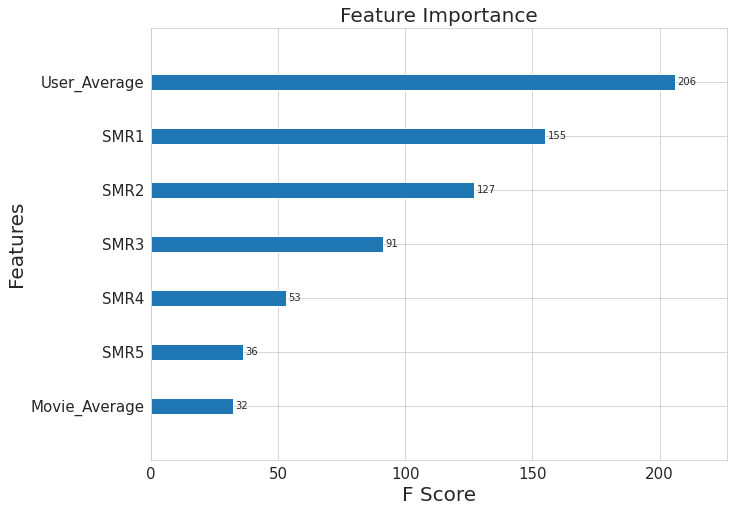

In [35]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

plot_importance(xgb,xgb_model)
